In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv(
    '/kaggle/input/data-for-k-means/data (2).csv',
    encoding='latin1'
)
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
data.shape

(541909, 8)

### 4 DATA PREPROCESSING

In [9]:
#Delete Missing Records
data.dropna(inplace=True)

In [10]:
# Handling negative values
data = data[data['Quantity'] > 0]
data[data['UnitPrice']<0].shape[0]

0

In [11]:
#Drop the negative values or quantity
data.drop(data[data['Quantity'] < 0].index, inplace=True)

### 5. Feature Engineering

In [12]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
new_data = data.groupby('CustomerID')['Sales'].sum().reset_index()
new_data

,CustomerID,Sales
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


In [13]:
num_trans = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
num_trans

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,756


In [14]:
#Calculating Last Transaction

#Converting 'InvoiceDate' to DateTime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Calculating 'Last Transaction' Days
data['Last Transaction'] = (data['InvoiceDate'].max()-data['InvoiceDate']).dt.days

##Grouping by 'CustomerID' and 'Country' and Calculating Maximum 'Last Transaction'
lt = data.groupby(['CustomerID', 'Country'])['Last Transaction'].max().reset_index()

#Merging with the number of transactions
merge_table = pd.merge(lt, num_trans, how='inner', on='CustomerID')
new_df = pd.merge(merge_table, new_data, how = 'inner', on='CustomerID')
print(lt)
print(new_df)

      CustomerID         Country  Last Transaction
0        12346.0  United Kingdom               325
1        12347.0         Iceland               366
2        12348.0         Finland               357
3        12349.0           Italy                18
4        12350.0          Norway               309
...          ...             ...               ...
4342     18280.0  United Kingdom               277
4343     18281.0  United Kingdom               180
4344     18282.0  United Kingdom               125
4345     18283.0  United Kingdom               336
4346     18287.0  United Kingdom               201

[4347 rows x 3 columns]
      CustomerID         Country  Last Transaction  InvoiceNo     Sales
0        12346.0  United Kingdom               325          1  77183.60
1        12347.0         Iceland               366        182   4310.00
2        12348.0         Finland               357         31   1797.24
3        12349.0           Italy                18         73   1757.55
4  

### 6. Removing Outliers

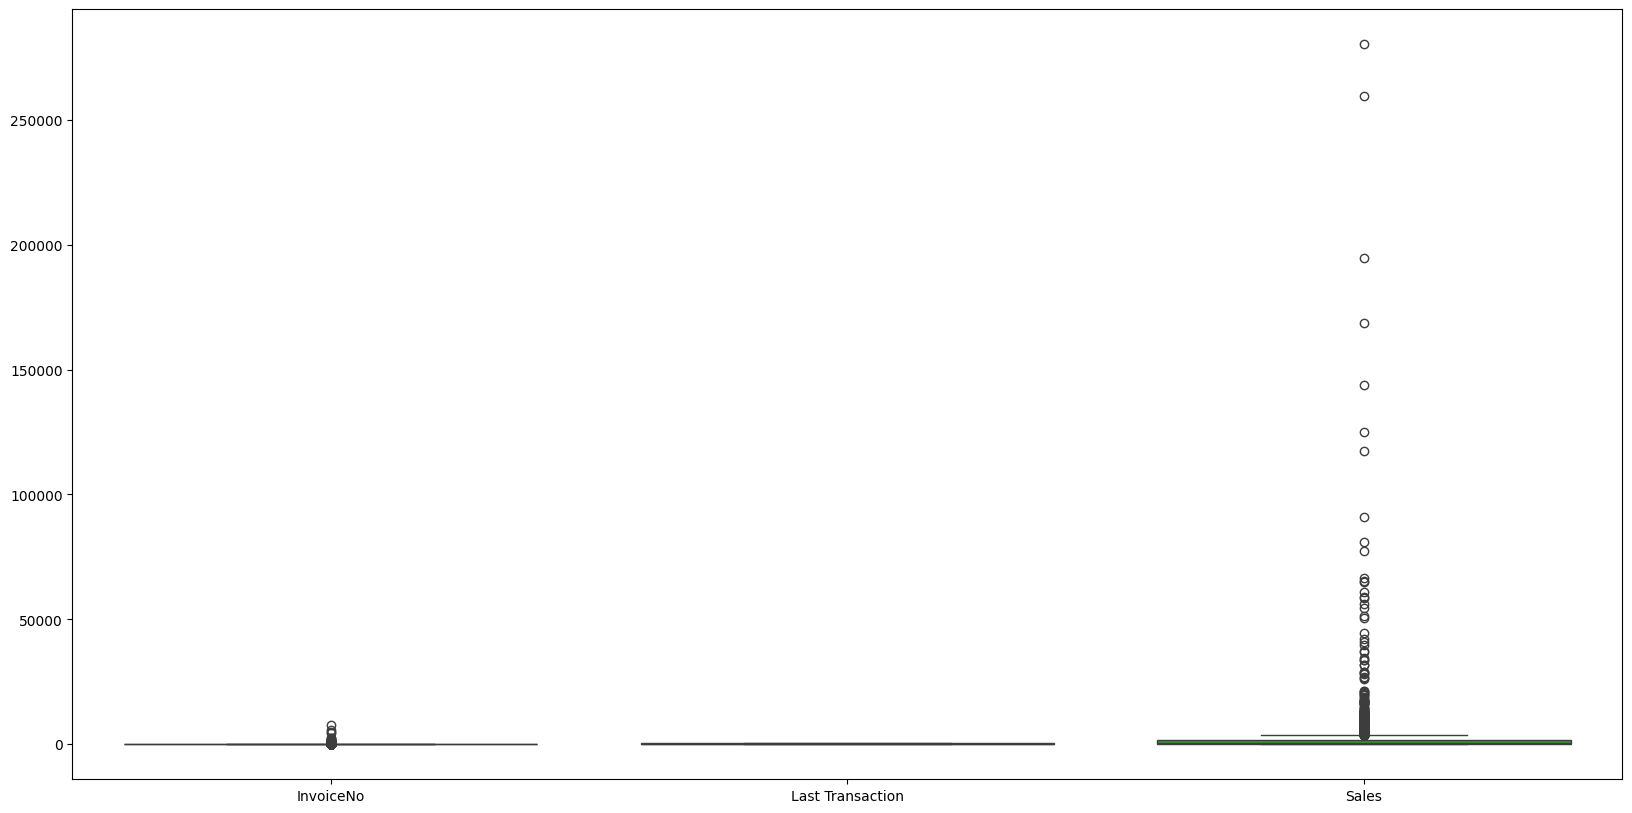

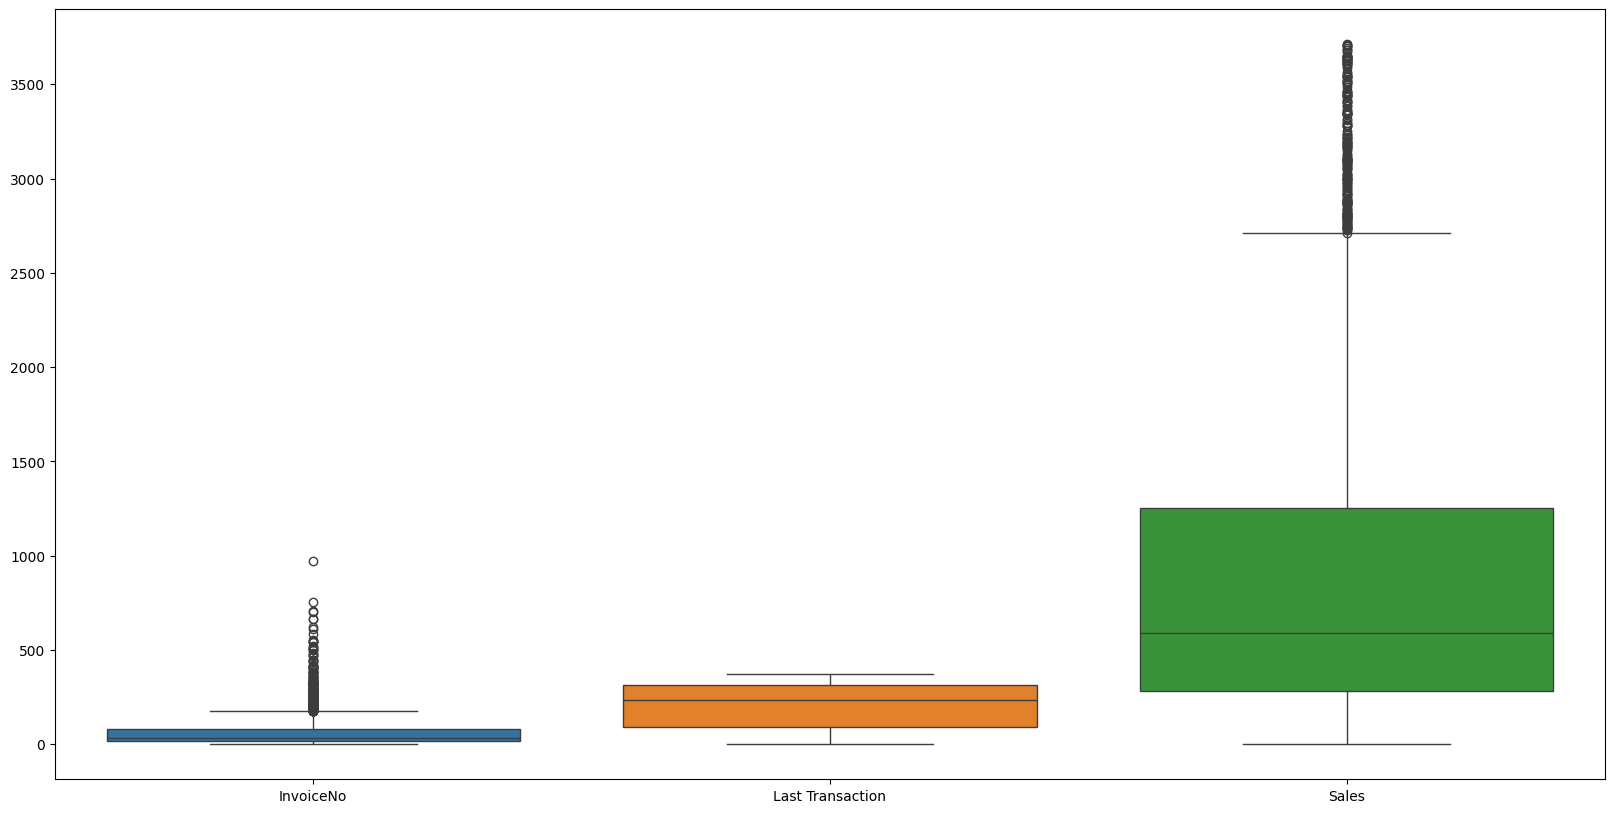

In [15]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

IQR = new_df['Sales'].quantile(0.75) - new_df['Sales'].quantile(0.25)
lower_limit = new_df['Sales'].quantile(0.25) - 1.5 * IQR
upper_limit = new_df['Sales'].quantile(0.75) + 1.5 * IQR
new_df_iqr = new_df[(new_df['Sales'] < upper_limit) & (new_df['Sales'] > lower_limit)]

plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df_iqr[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

new_df_iqr.reset_index(drop=True, inplace=True)

### 7. Normalization of Given Dataset using MinMaxScaler

In [16]:
from sklearn.preprocessing import MinMaxScaler
new2_df= new_df_iqr[['Last Transaction','InvoiceNo','Sales']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new2_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = ['Last Transaction','InvoiceNo','Sales']
scaled_df['Country'] = new_df_iqr['Country']
scaled_df

,Last Transaction,InvoiceNo,Sales,Country
0,0.957105,0.030960,0.484200,Finland
1,0.048257,0.074303,0.473507,Italy
2,0.828418,0.016512,0.090092,Norway
3,0.793566,0.086687,0.675160,Norway
4,0.544236,0.003096,0.023978,Bahrain
...,...,...,...,...
3918,0.742627,0.009288,0.048656,United Kingdom
3919,0.482574,0.006192,0.021774,United Kingdom
3920,0.335121,0.011352,0.047969,United Kingdom
3921,0.900804,0.779154,0.564388,United Kingdom


### 8. K-Means Clustering - Plotting the Graph using Elbow Method

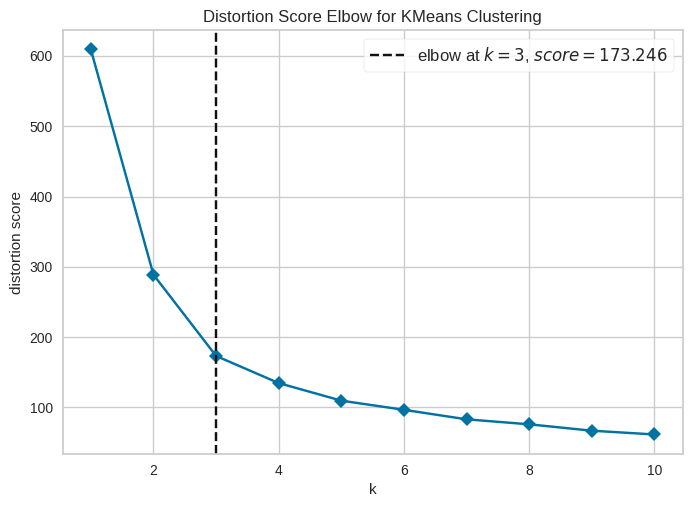

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_k)        # Fit data to visualizer
visualizer.show()

### 9. Model Evaluation

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, model.labels_, metric='euclidean')
print(score)

from sklearn.cluster import AgglomerativeClustering
hierarchial = AgglomerativeClustering(n_clusters=3)
y_predicted_hierarchial = hierarchial.fit_predict(df_k)
df_k['clusters_hierarchial']= y_predicted_hierarchial
df_k.head(30)

0.34303121403390724


,Last Transaction,InvoiceNo,Sales,clusters_hierarchial
0,0.957105,0.030960,0.484200,2
1,0.048257,0.074303,0.473507,0
2,0.828418,0.016512,0.090092,1
3,0.793566,0.086687,0.675160,2
4,0.544236,0.003096,0.023978,0
5,0.619303,0.058824,0.290805,0
6,0.571046,0.012384,0.123768,0
7,0.871314,0.059856,0.757436,2
8,0.402145,0.018576,0.314691,0
9,0.536193,0.132095,0.717194,0


In [19]:
km = KMeans(n_clusters = 3)
y_predicted = km.fit_predict(df_k)
df_k['clusters']= y_predicted
df_k

,Last Transaction,InvoiceNo,Sales,clusters_hierarchial,clusters
0,0.957105,0.030960,0.484200,2,0
1,0.048257,0.074303,0.473507,0,1
2,0.828418,0.016512,0.090092,1,2
3,0.793566,0.086687,0.675160,2,0
4,0.544236,0.003096,0.023978,0,1
...,...,...,...,...,...
3918,0.742627,0.009288,0.048656,1,2
3919,0.482574,0.006192,0.021774,0,1
3920,0.335121,0.011352,0.047969,0,1
3921,0.900804,0.779154,0.564388,2,0


In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, km.labels_, metric='euclidean')
print(score)

0.8177644402564616


In [21]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=3)
y_predicted_hierarchical = hierarchical.fit_predict(df_k)
df_k['clusters_hierarchical']= y_predicted_hierarchical
df_k.head(20)

,Last Transaction,InvoiceNo,Sales,clusters_hierarchial,clusters,clusters_hierarchical
0,0.957105,0.030960,0.484200,2,0,1
1,0.048257,0.074303,0.473507,0,1,0
2,0.828418,0.016512,0.090092,1,2,2
3,0.793566,0.086687,0.675160,2,0,1
4,0.544236,0.003096,0.023978,0,1,0
5,0.619303,0.058824,0.290805,0,1,0
6,0.571046,0.012384,0.123768,0,1,0
7,0.871314,0.059856,0.757436,2,0,1
8,0.402145,0.018576,0.314691,0,1,0
9,0.536193,0.132095,0.717194,0,1,0


In [23]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2,min_samples = 4 )
y_predicted_dbscan = dbscan.fit_predict(df_k)
df_k['clusters_dbscan'] = y_predicted_dbscan
df_k

,Last Transaction,InvoiceNo,Sales,clusters_hierarchial,clusters,clusters_hierarchical,clusters_dbscan
0,0.957105,0.030960,0.484200,2,0,1,0
1,0.048257,0.074303,0.473507,0,1,0,1
2,0.828418,0.016512,0.090092,1,2,2,2
3,0.793566,0.086687,0.675160,2,0,1,0
4,0.544236,0.003096,0.023978,0,1,0,1
...,...,...,...,...,...,...,...
3918,0.742627,0.009288,0.048656,1,2,2,2
3919,0.482574,0.006192,0.021774,0,1,0,1
3920,0.335121,0.011352,0.047969,0,1,0,1
3921,0.900804,0.779154,0.564388,2,0,1,0


In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, dbscan.labels_, metric='euclidean')
print(score)

0.8815232511374497
